<a href="https://colab.research.google.com/github/lonanni/WaterNets/blob/main/Downgrading_Camera_LandSat8toPiCamera3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TinyMLDrive/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1CTqSzBrCYC0m9cNgwEZtlymQ-3SMJG99/TinyMLDrive


In [ ]:
!pip install git+https://github.com/lonanni/WaterNets

  Cloning https://github.com/lonanni/WaterNets to /tmp/pip-req-build-wq7zdy17
  Running command git clone --filter=blob:none --quiet https://github.com/lonanni/WaterNets /tmp/pip-req-build-wq7zdy17
  Resolved https://github.com/lonanni/WaterNets to commit 1b2b4046d0d1f252c15904e57ac3653e48f840fb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.2/359.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 kB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.6 MB/s eta 0:00:00
  Created whe

In [ ]:
from WaterNets_project import waternet_trainingdata as wt
import os
import rasterio
import matplotlib.pyplot as plt
import math
import numpy as np

Assuming the Raspberry PI Camera 3, the Diagonal FoV is 75° and 16:9 aspect ratio, so roughly 73° horizontal FoV and 45° vertical FoV.
there are 4608 pixels x 2592 pixel.
We compute the FoV in km - assuming the satellite will be in low Earth orbit (let's assume 400 km)-, and the spatial resolution

In [ ]:
def compute_pixelspatialresolution(FoV_w= 73, FoV_h= 45, pixel_w = 4608, pixel_h= 2592, distance= 400):
  """
  function that computes for a given angular  diameter of the FoV in degrees,
  for a given number of pixels, and a given distance of the satellite in km,
  the spatial resolution of each pixel in km
  Args:
  FoV_w (float): angular diameter of the FoV in degrees along the width
  FoV_h (float): angular diameter of the FoV in degrees along the height
  pixel_w (float): number of pixel along the width
  pixel_h (float): number of pixel along the height
  return:
  spatial resolution of the pixel in km along the x and y dimension

  """

  h = math.tan(math.radians(FoV_h)/2) * distance * 2 #  FoV in km given the distance of the satellite along the y
  w = math.tan(math.radians(FoV_w)/2) * distance * 2 #  FoV in km given the distance of the satellite along the x

  print("FoV in km in the x and y direction:",w,h)
  print("FoV in km in the x and y direction for each pixel:",w/pixel_w,h/pixel_h)
  return(w/pixel_w, h/pixel_h)

In [ ]:
pix_x_res, pix_y_res = compute_pixelspatialresolution()

FoV in km in the x and y direction: 591.9688600227901 331.370849898476
FoV in km in the x and y direction for each pixel: 0.128465464414668 0.12784369209046142


We are now going to transform the LandSat8 images to match the characteristics the Raspberry Pi Camera 3 would prioduces

In [ ]:
def load_img(file_path, date):
  '''
  Returns the SR image for the given location and date, once the path is given
  Args:
  file_path (str): path where to find the image
  date (str): date the image is registered
  '''
  file_path_sr = os.path.join(file_path,os.path.join(file_path,'SR/'+date),os.listdir(os.path.join(file_path,'SR/'+date))[0])
  return(wt.scale_im(rasterio.open(file_path_sr)))

In [ ]:
sr_image = load_img('/content/drive/MyDrive/TinyML/Satellite/Portsmouth', "2021-07-01")


The images collected from the RaspberryPi Camera, will have a width of 592 km, and an height of = 331 km, if the satellite is at 400 km

In [ ]:
import skimage
from skimage.transform import downscale_local_mean


In [ ]:
def scaler_for_downgrading(new_pix_FoV, initial_pix_FoV=0.03):
  '''
  Function to obtain the scaler for the downgrading given the initial resolution
  and the new resolution
  Args:
  new_pix_FoV (str): the pixel resolution as spatial resolution in km for the new instrument
  initial_pix_FoV (str): the pixel resolution of the current image as spatial resolution in km
  '''
  return(int(new_pix_FoV/initial_pix_FoV))

In [ ]:
image_downscaled = downscale_local_mean(sr_image, (scaler_for_downgrading(pix_x_res), scaler_for_downgrading(pix_y_res),1))


Text(0.5, 1.0, 'Downgraded - PiCamera3')

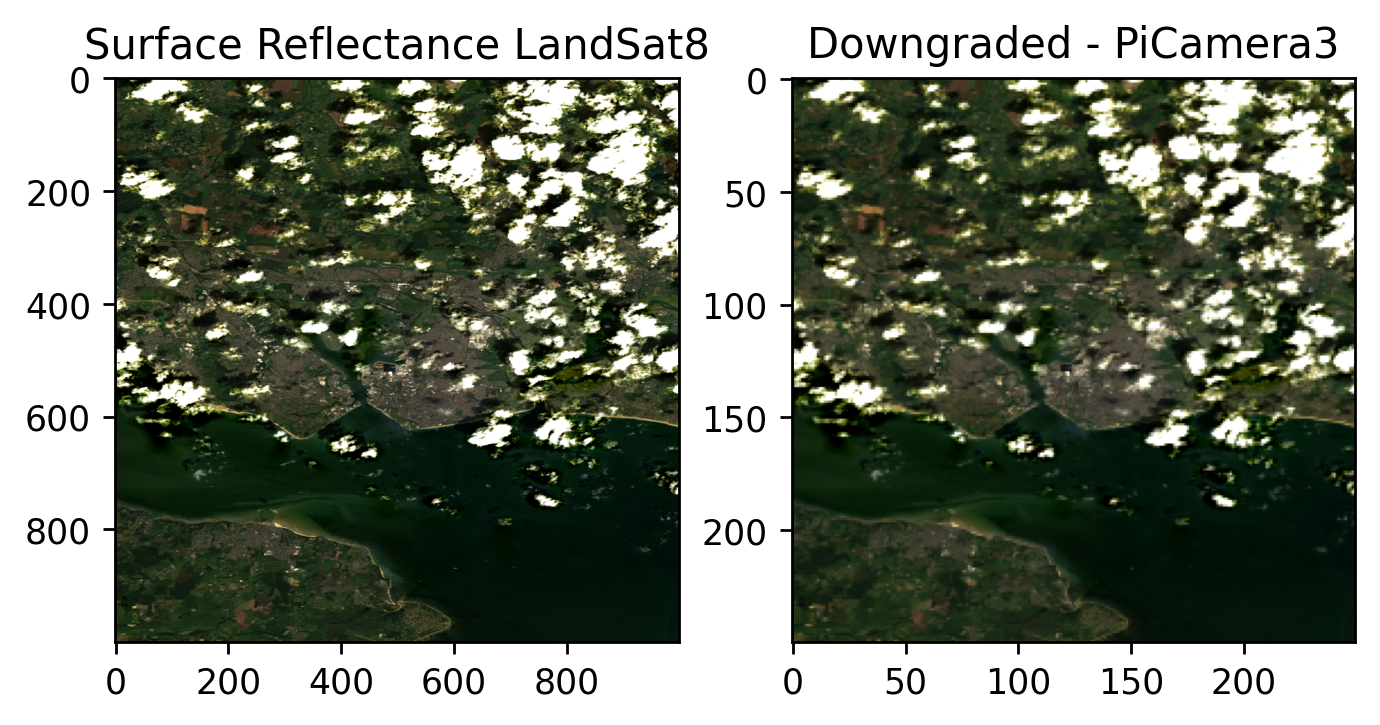

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=250)

ax[0].imshow(sr_image)
ax[0].set_title("Surface Reflectance LandSat8")
ax[1].imshow(image_downscaled)
ax[1].set_title("Downgraded - PiCamera3")